<a href="https://colab.research.google.com/github/star-plant/ENFU-AI-SEMI/blob/main/study/snntorch/tutorial_4_advanced_neurons_kr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)

# snnTorch - 2nd Order Spiking Neuron Models
## Tutorial 4
### By Jason K. Eshraghian (www.ncg.ucsc.edu)

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_4_advanced_neurons.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)

The snnTorch tutorial series is based on the following paper. If you find these resources or code useful in your work, please consider citing the following source:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>

# Introduction
이 튜토리얼에서는 다음 내용을 학습합니다:
* 더 발전된 형태의 LIF(Leaky Integrate-and-Fire) 뉴런 모델: `Synaptic` 및 `Alpha`

아래 셀을 클릭한 뒤 `Shift+Enter`를 눌러 snnTorch의 최신 PyPi 배포판을 설치하세요.


In [1]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 7.4 MB/s eta 0:00:00


In [2]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
#@title Plotting Settings

def plot_spk_cur_mem_spk(spk_in, syn_rec, mem_rec, spk_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(4, figsize=(8,7), sharex=True,
                        gridspec_kw = {'height_ratios': [0.4, 1, 1, 0.4]})

  # Plot input current
  splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title("Synaptic Conductance-based Neuron Model With Input Spikes")
  ax[0].set_yticks([])

  # Plot membrane potential
  ax[1].plot(syn_rec.detach().numpy())
  ax[1].set_ylim([0, 0.5])
  ax[1].set_ylabel("Synaptic Current ($I_{syn}$)")
  plt.xlabel("Time step")

  # Plot membrane potential
  ax[2].plot(mem_rec.detach().numpy())
  ax[2].set_ylim([0, 1.5])
  ax[2].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[2].axhline(y=1, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk_rec, ax[3], s=400, c="black", marker="|")
  plt.ylabel("Output spikes")
  ax[3].set_yticks([])

  plt.show()

def plot_spk_mem_spk(spk_in, mem_rec, spk_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True,
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4]})

  # Plot input current
  splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)
  ax[0].set_yticks([])

  # Plot membrane potential
  ax[1].plot(mem_rec.detach())
  ax[1].set_ylim([0, 0.6])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk_rec, ax[2], s=400, c="black", marker="|")
  ax[2].set_yticks([])
  ax[2].set_ylabel("Output Spikes")

  plt.show()

# 1. 시냅스 전도 기반 LIF 뉴런 모델

이전 튜토리얼에서 살펴본 뉴런 모델은 입력 전압 스파이크가 시냅스 전류에 즉각적인 변화(점프)를 일으키고, 이 전류가 막전위(membrane potential)에 기여한다고 가정합니다.  
그러나 실제로는 스파이크가 발생하면, 시냅스 전류는 *점진적으로* 변화합니다. 즉, 전(前)시냅스(pre-synaptic) 뉴런에서 후(後)시냅스(post-synaptic) 뉴런으로 신경전달물질이 서서히 방출됩니다.  
시냅스 전도 기반 LIF 모델은 이러한 입력 전류의 점진적 시간 변화를 반영합니다.


## 1.1 시냅스 전류 모델링

전(前)시냅스(pre-synaptic) 뉴런이 발화(spike)하면, 전압 스파이크는 해당 뉴런의 축삭(axon)을 따라 전달됩니다.  
이 신호는 시냅스 소포(vesicle)가 시냅스 간극(synaptic cleft)으로 신경전달물질(neurotransmitter)을 방출하도록 유도합니다.  
방출된 신경전달물질은 후(後)시냅스(post-synaptic) 수용체를 활성화하며, 이 수용체들은 후시냅스 뉴런으로 유입되는 유효 전류에 직접적인 영향을 미칩니다.  
아래 그림은 대표적인 두 종류의 흥분성 수용체인 AMPA와 NMDA를 보여줍니다.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_6_synaptic.png?raw=true' width="600">
</center>

시냅스 전류의 가장 단순한 모델은, 매우 짧은 시간 척도에서 전류가 급격히 증가한 후, 비교적 느린 지수 감쇠(exponential decay)를 따르는 형태로 가정합니다.  
이는 위 그림의 AMPA 수용체 반응과 유사하며, Lapicque 모델의 막전위(membrane potential) 동역학과도 매우 비슷합니다.

시냅스 모델에는 두 개의 지수 감쇠 항이 존재합니다:  
- $I_{\rm syn}(t)$: 시냅스 전류  
- $U_{\rm mem}(t)$: 막전위  

각 항의 연속된 값 비율(감쇠율)은 다음과 같이 정의됩니다.  
시냅스 전류의 감쇠율을 $\alpha$, 막전위의 감쇠율을 $\beta$라고 하면:

$$ \alpha = e^{-\Delta t/\tau_{\rm syn}}$$

$$ \beta = e^{-\Delta t/\tau_{\rm mem}}$$

여기서 $\Delta t$는 단일 시간 스텝의 길이이며, 이후 계산에서는 $\Delta t = 1$로 정규화합니다.  
$\tau_{\rm syn}$은 시냅스 전류의 시정수(time constant)를 나타내며, 이는 $\tau_{\rm mem}$이 막전위의 시정수를 나타내는 것과 유사합니다.  
$\beta$는 이전 튜토리얼에서와 동일한 방식으로 유도하며, $\alpha$ 역시 비슷하게 구합니다.

시냅스 전류와 막전위의 업데이트 식은 다음과 같습니다.

$$I_{\rm syn}[t+1]=\underbrace{\alpha I_{\rm syn}[t]}_{\text{감쇠(decay)}} + \underbrace{WX[t+1]}_{\text{입력(input)}}$$

$$U[t+1] = \underbrace{\beta U[t]}_{\text{감쇠(decay)}} + \underbrace{I_{\rm syn}[t+1]}_{\text{입력(input)}} - \underbrace{R[t]}_{\text{리셋(reset)}}$$

발화 조건은 기존 LIF 뉴런과 동일합니다.

$$S_{\rm out}[t] = \begin{cases} 1, &\text{if}~U[t] > U_{\rm thr} \\
0, &\text{그 외 경우} \end{cases}$$


## 1.2 snnTorch의 시냅스 뉴런 모델

시냅스 전도 기반 뉴런 모델은 시냅스 전류의 동역학과 수동 막전위(passive membrane)를 결합한 형태입니다.  
이 모델을 생성할 때는 두 개의 입력 인자가 필요합니다.

* $\alpha$: 시냅스 전류의 감쇠율(decay rate)  
* $\beta$: 막전위의 감쇠율 (Lapicque 모델과 동일)


In [4]:
# Temporal dynamics
alpha = 0.9
beta = 0.8
num_steps = 200

# Initialize 2nd-order LIF neuron
lif1 = snn.Synaptic(alpha=alpha, beta=beta)

이 뉴런의 사용법은 이전 LIF 뉴런과 동일하지만, 이제 시냅스 전류 `syn`이 입·출력에 추가됩니다.

입력
- `spk_in`: 가중합 입력 전압 스파이크 $WX[t]$가 시간 순서대로 들어감
- `syn`: 이전 시각의 시냅스 전류 $I_{\rm syn}[t-1]$
- `mem`: 이전 시각의 막전위 $U[t-1]$

출력
- `spk_out`: 출력 스파이크 $S[t]$ (스파이크면 ‘1’, 아니면 ‘0’)
- `syn`: 현재 시각의 시냅스 전류 $I_{\rm syn}[t]$
- `mem`: 현재 시각의 막전위 $U[t]$

모든 값은 `torch.Tensor` 타입이어야 합니다. 일반성을 잃지 않고, 뉴런 모델은 시간축을 한 스텝 뒤로 이동해 표현했습니다.

주기적인 스파이킹 입력을 가해, 전류와 막전위가 시간에 따라 어떻게 변하는지 확인해 봅니다.


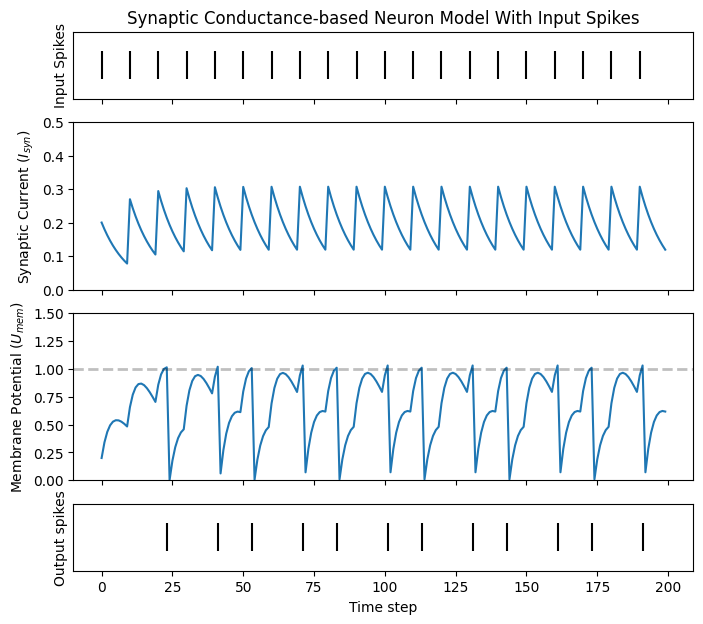

In [5]:
# Periodic spiking input, spk_in = 0.2 V
w = 0.2
spk_period = torch.cat((torch.ones(1)*w, torch.zeros(9)), 0)
spk_in = spk_period.repeat(20)

# Initialize hidden states and output
syn, mem = lif1.init_synaptic()
spk_out = torch.zeros(1)
syn_rec = []
mem_rec = []
spk_rec = []

# Simulate neurons
for step in range(num_steps):
  spk_out, syn, mem = lif1(spk_in[step], syn, mem)
  spk_rec.append(spk_out)
  syn_rec.append(syn)
  mem_rec.append(mem)

# convert lists to tensors
spk_rec = torch.stack(spk_rec)
syn_rec = torch.stack(syn_rec)
mem_rec = torch.stack(mem_rec)

plot_spk_cur_mem_spk(spk_in, syn_rec, mem_rec, spk_rec,
                     "Synaptic Conductance-based Neuron Model With Input Spikes")

이 모델은 Lapicque 뉴런 모델에서와 같이 `reset_mechanism`과 `threshold`를 선택적 입력 인자로 제공합니다.  
요약하면, 각 스파이크는 시냅스 전류 $I_{\rm syn}$에 시간 이동된 지수 감쇠 성분을 하나씩 더하며, 이들이 모두 합산됩니다.  
그 후 이 전류는 [튜토리얼 2](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)에서 유도된 수동 막전위 방정식에 의해 적분되어 출력 스파이크를 생성합니다.  
아래 그림은 이 과정을 도식화한 것입니다.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_7_stein.png?raw=true' width="600">
</center>


## 1.3 1차(1st-Order) vs. 2차(2nd-Order) 뉴런

자연스럽게 떠오르는 질문은 다음과 같습니다.  
*언제 1차 LIF 뉴런을 사용하고, 언제 2차 LIF 뉴런을 사용해야 할까?*
이에 대한 명확한 결론은 없지만, 개인적인 실험을 통해 얻은 직관을 공유합니다.

### 2차 뉴런이 더 유리한 경우
- 입력 데이터의 **시간적 관계**가 장기(time-scale가 길게) 걸쳐 나타나는 경우
- 입력 스파이크 패턴이 **희소(sparse)**한 경우

2차 뉴런 모델은 두 개의 재귀식(감쇠율 $\alpha$와 $\beta$)을 가지므로, 입력 스파이크를 더 오랫동안 ‘유지’할 수 있습니다.  
이는 장기적 관계를 보존하는 데 유리합니다.

추가적으로, 다음 경우에도 활용할 수 있습니다.
- **시간 코딩(temporal coding)**이 중요한 경우

정확한 스파이크 타이밍을 제어하려면 2차 뉴런이 더 용이합니다.  
`Leaky` 모델에서는 입력과 출력 스파이크가 거의 동기적으로 발생하지만, 2차 모델에서는 시냅스 전류가 막전위를 ‘스무딩(smoothing)’ 처리(저역통과 필터링)하므로, $U[t]$가 서서히 상승하는 유한한 상승 시간(rise time)을 갖습니다.  
즉, 입력 스파이크 대비 출력 스파이크가 지연되는 현상이 나타납니다(앞선 시뮬레이션 참고).

---

### 1차 뉴런이 더 유리한 경우
- 위 조건에 해당하지 않는 대부분의 경우
- 또는, 위 조건에 해당하더라도 여전히 단순 모델이 더 효율적인 경우

1차 뉴런(`Leaky` 등)은 방정식이 하나 적으므로, 역전파(backpropagation) 과정이 조금 더 단순해집니다.  
또한, `Synaptic` 모델에서 $\alpha=0$으로 설정하면 `Leaky` 모델과 기능적으로 동일합니다.  
간단한 데이터셋에 대한 하이퍼파라미터 탐색 결과, 최적값이 $\alpha$를 0에 가깝게 만드는 경향이 있었습니다.  
하지만 데이터 복잡도가 증가할수록, $\alpha$ 값이 더 커질 수 있습니다.


# 2. Alpha Neuron Model (Hacked Spike Response Model)

스파이크 반응 모델(Spike Response Model, SRM)의 재귀적(recursive) 버전인 **‘Alpha’ 뉴런**도 제공되며, `snn.Alpha`로 호출할 수 있습니다.  
지금까지 다룬 뉴런 모델들은 모두 수동 막전위(passive membrane) 모델을 기반으로 하였으며,  
이들의 동역학은 보통 미분방정식(ODE)으로 표현되었습니다.

반면, **SRM 계열 모델**은 이를 **필터(filter)** 관점에서 해석합니다.  
입력 스파이크가 도착하면, 해당 스파이크는 필터와 **컨볼루션(convolution)**되어 막전위 응답을 생성합니다.  
이 필터의 형태는 Lapicque 뉴런에서처럼 **지수(exponential)**일 수도 있고,  
여러 지수의 합처럼 더 복잡한 형태일 수도 있습니다.

SRM 모델의 장점은, 필터에 특정 특성을 포함시키는 방식으로  
불응기(refractoriness), 임계값 적응(threshold adaptation) 등 다양한 기능을 임의로 추가할 수 있다는 점입니다.

<left>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/exp.gif?raw=true' width="400">
</left>

<right>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/alpha.gif?raw=true' width="400">
</right>


## 2.1 알파(Alpha) 뉴런 모델링

이 과정을 수식으로 나타내면 다음과 같습니다.

$$U_{\rm mem}(t) = \sum_i W(\epsilon * S_{\rm in})(t)$$

여기서 입력 스파이크 $S_{\rm in}$은 **스파이크 반응 커널** $\epsilon(\cdot)$과 컨볼루션되며,  
그 결과는 시냅스 가중치 $W$로 스케일링됩니다.  

위 그림에서,
- **왼쪽 커널**: 지수 감쇠 함수 → Lapicque의 1차 뉴런 모델에 해당  
- **오른쪽 커널**: 알파 함수(alpha function)

알파 함수의 정의는 다음과 같습니다.

$$\epsilon(t) = \frac{t}{\tau}e^{1-t/\tau}\Theta(t)$$

- $\tau$: 알파 커널의 시정수(time constant)  
- $\Theta$: 헤비사이드(Heaviside) 스텝 함수  

대부분의 커널 기반 방법은 알파 함수를 채택하는데,  
이는 뉴런의 정확한 스파이크 시각을 지정하는 데 유용한 **시간 지연(time-delay)**을 제공하기 때문입니다.

---

snnTorch에서는 스파이크 반응 모델을 필터 형태로 직접 구현하지 않고,  
**재귀(recursive) 형태**로 변환하여 이전 시각 값만으로 다음 시각 값을 계산합니다.  
이 방식은 학습 시 메모리 사용량을 크게 줄여줍니다.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_9_alpha.png?raw=true' width="600">
</center>

---

막전위가 이제 두 개의 지수 함수의 합으로 결정되므로,  
각 지수 함수는 독립적인 감쇠율을 가집니다.

- $\alpha$: **양의 지수 항**의 감쇠율  
- $\beta$: **음의 지수 항**의 감쇠율


In [6]:
alpha = 0.8
beta = 0.7

# initialize neuron
lif2 = snn.Alpha(alpha=alpha, beta=beta, threshold=0.5)

이 뉴런의 사용 방식은 이전 뉴런들과 동일하지만,  
두 개의 지수 함수 합을 사용하므로 시냅스 전류 `syn`을  
**흥분성(excitatory)**과 **억제성(inhibitory)** 성분으로 나누어야 합니다.

---

### 입력
- `spk_in`: 가중합 입력 전압 스파이크 $WX[t]$ (시간 순서대로 입력)
- `syn_exc`: 이전 시각 $t-1$의 흥분성 시냅스 전류 $I_{\rm syn-exc}[t-1]$
- `syn_inh`: 이전 시각 $t-1$의 억제성 시냅스 전류 $I_{\rm syn-inh}[t-1]$
- `mem`: 이전 시각 $t-1$의 막전위 $U_{\rm mem}[t-1]$

---

### 출력
- `spk_out`: 현재 시각 $t$의 출력 스파이크 $S_{\rm out}[t]$  
  (스파이크 발생 시 ‘1’, 그렇지 않으면 ‘0’)
- `syn_exc`: 현재 시각 $t$의 흥분성 시냅스 전류 $I_{\rm syn-exc}[t]$
- `syn_inh`: 현재 시각 $t$의 억제성 시냅스 전류 $I_{\rm syn-inh}[t]$
- `mem`: 현재 시각 $t$의 막전위 $U_{\rm mem}[t]$

---

다른 뉴런 모델들과 마찬가지로, 모든 값은 `torch.Tensor` 타입이어야 합니다.


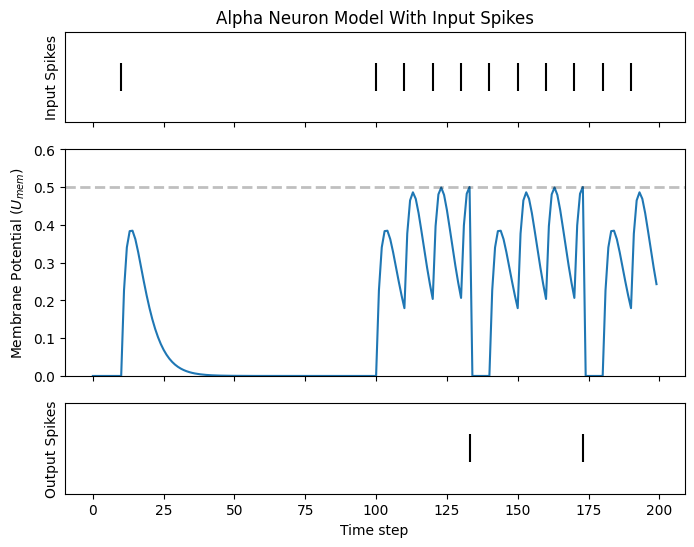

In [7]:
# input spike: initial spike, and then period spiking
w = 0.85
spk_in = (torch.cat((torch.zeros(10), torch.ones(1), torch.zeros(89),
                     (torch.cat((torch.ones(1), torch.zeros(9)),0).repeat(10))), 0) * w).unsqueeze(1)

# initialize parameters
syn_exc, syn_inh, mem = lif2.init_alpha()
mem_rec = []
spk_rec = []

# run simulation
for step in range(num_steps):
  spk_out, syn_exc, syn_inh, mem = lif2(spk_in[step], syn_exc, syn_inh, mem)
  mem_rec.append(mem.squeeze(0))
  spk_rec.append(spk_out.squeeze(0))

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_spk_mem_spk(spk_in, mem_rec, spk_rec, "Alpha Neuron Model With Input Spikes")

Lapicque와 Synaptic 모델과 마찬가지로, Alpha 모델도 임계값(threshold)과 리셋 메커니즘(reset mechanism)을 수정할 수 있는 옵션을 제공합니다.


## 2.2 실무적 고려사항

시냅스(Synaptic) 뉴런에서도 언급했듯이, 모델이 복잡해질수록 학습 시 역전파(backpropagation) 과정도 복잡해집니다.  
제 실험에서는 Alpha 뉴런이 Synaptic 또는 Leaky 뉴런보다 우수한 성능을 보인 경우는 아직 없습니다.  
양(positive)·음(negative) 지수 함수를 모두 학습에 포함시키는 것은,  
더 복잡한 뉴런 동역학이 주는 잠재적 이점보다 **그래디언트 계산 난이도 증가**로 인한 손해가 더 커 보입니다.

그러나 SRM 모델을 여기서처럼 재귀(recursive) 방식이 아닌, **시간에 따라 변화하는 커널(time-varying kernel)** 형태로 구현할 경우에는  
단순한 뉴런 모델과 비슷한 성능을 내는 것으로 보입니다.  
예시로 다음 논문을 참고할 수 있습니다.

> [*Sumit Bam Shrestha and Garrick Orchard, "SLAYER: Spike layer error reassignment in time", Proceedings of the 32nd International Conference on Neural Information Processing Systems, pp. 1419-1328, 2018.*](https://arxiv.org/abs/1810.08646)

Alpha 뉴런은 SRM 기반 모델을 snnTorch로 이식(porting)할 수 있는 옵션을 제공하기 위해 포함된 것이며,  
snnTorch에서 직접 학습시키는 용도로는 큰 효과를 보이지 않는 편입니다.


# Conclusion

이번 튜토리얼에서는 snnTorch에서 제공하는 모든 LIF 뉴런 모델을 다루었습니다.  
간단히 요약하면 다음과 같습니다.

- **Lapicque**: RC 회로 파라미터에 기반한 물리적으로 정확한 모델
- **Leaky**: 단순화된 1차(1st-order) 모델
- **Synaptic**: 시냅스 전류의 변화를 반영한 2차(2nd-order) 모델
- **Alpha**: 막전위가 알파 함수(alpha function)를 추적하는 2차(2nd-order) 모델

일반적으로 네트워크 학습에는 `Leaky`와 `Synaptic`이 가장 유용합니다.  
`Lapicque`는 물리적으로 정밀한 모델을 시연할 때 적합하며,  
`Alpha`는 SRM 뉴런의 동작을 재현하는 용도로만 의도되었습니다.

이러한 조금 더 발전된 뉴런들을 사용해 네트워크를 구축하는 절차는  
[Tutorial 3](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)와 동일합니다.

참고 문서: [snnTorch 문서](https://snntorch.readthedocs.io/en/latest/snntorch.html)

이 프로젝트가 마음에 든다면, GitHub 저장소에 ⭐을 눌러 주시면  
가장 쉽고 좋은 방식으로 프로젝트를 지원하실 수 있습니다.


## Further Reading
* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)
* [snnTorch documentation](https://snntorch.readthedocs.io/en/latest/snntorch.html) of the Lapicque, Leaky, Synaptic, and Alpha models
* [*Neuronal Dynamics:
From single neurons to networks and models of cognition*](https://neuronaldynamics.epfl.ch/index.html) by
Wulfram Gerstner, Werner M. Kistler, Richard Naud and Liam Paninski.
* [Theoretical Neuroscience: Computational and Mathematical Modeling of Neural Systems](https://mitpress.mit.edu/books/theoretical-neuroscience) by Laurence F. Abbott and Peter Dayan